In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme()

pd.set_option('display.max_rows', 25)          
pd.set_option('display.max_columns', 100)      
pd.set_option('display.width', None)             
pd.set_option('display.max_colwidth', 100)       
pd.set_option("display.precision", 6)           

import warnings
warnings.filterwarnings('ignore')

In [2]:
from pathlib import Path
import os.path
from PIL import Image
import tensorflow as tf

# Create a list with the filepaths for training and testing

# path of "./dataset/natural_images" from computer
dloadpaths = Path('./data_vehicle_recognition/vehicles') 

imagepaths = list(dloadpaths.rglob('**/*.jpg'))    

len(imagepaths)     # --> 522 images

522

In [3]:
# DATAFRAME

def images(imagepath):
    
    """ Create a DataFrame with the imagepath and the labels of the pictures
    """

    labels = [str(imagepath[i]).split("\\")[-2] for i in range(len(imagepath))]
    
    # samples (pd.Series)
    imagepath = pd.Series(imagepath, name='Imagepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate imagepath and labels
    df01 = pd.concat([imagepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df01 = df01.sample(frac=1,random_state=42).reset_index(drop = True)
    
    return df01

# Dataframe with imagepaths
df01 = images(imagepaths)

print(f'Number of pictures: {df01.shape[0]}\n')
print(f'Number of different labels: {len(df01.Label.unique())}\n')
print(f'Labels: {df01.Label.unique()}')

Number of pictures: 522

Number of different labels: 9

Labels: ['scooty' 'bike' 'car' 'boat' 'helicopter' 'truck' 'bus' 'plane' 'cycle']


In [4]:
df01.head()

,Imagepath,Label
0,data_vehicle_recognition\vehicles\scooty\images (15).jpg,scooty
1,data_vehicle_recognition\vehicles\scooty\images (20).jpg,scooty
2,data_vehicle_recognition\vehicles\bike\2Q__ (6).jpg,bike
3,data_vehicle_recognition\vehicles\car\images (10).jpg,car
4,data_vehicle_recognition\vehicles\boat\images (12).jpg,boat


In [5]:
df01.Label.value_counts()

Label
car           65
cycle         65
scooty        63
helicopter    57
bike          55
boat          55
truck         55
bus           55
plane         52
Name: count, dtype: int64

In [6]:
# all categories with same size: 52

list_indizes = []

[list_indizes.append(i) for i in df01[df01.Label == "car"].iloc[:13,:].index]

[list_indizes.append(i) for i in df01[df01.Label == "cycle"].iloc[:13,:].index]

[list_indizes.append(i) for i in df01[df01.Label == "scooty"].iloc[:11,:].index]

[list_indizes.append(i) for i in df01[df01.Label == "helicopter"].iloc[:5,:].index]

[list_indizes.append(i) for i in df01[df01.Label == "bike"].iloc[:3,:].index]

[list_indizes.append(i) for i in df01[df01.Label == "boat"].iloc[:3,:].index]

[list_indizes.append(i) for i in df01[df01.Label == "truck"].iloc[:3,:].index]

[list_indizes.append(i) for i in df01[df01.Label == "bus"].iloc[:3,:].index]

len(list_indizes)

df01.drop(index=list_indizes,inplace=True)

df01.Label.value_counts()

# sns.countplot(data=df01,x="Label",palette="viridis",order=df01.Label.value_counts().index)

df01.reset_index(drop=True,inplace=True)

df01

,Imagepath,Label
0,data_vehicle_recognition\vehicles\truck\2Q__.jpg,truck
1,data_vehicle_recognition\vehicles\bus\Z (12).jpg,bus
2,data_vehicle_recognition\vehicles\plane\9k_ (6).jpg,plane
3,data_vehicle_recognition\vehicles\bus\images (12).jpg,bus
4,data_vehicle_recognition\vehicles\truck\images (18).jpg,truck
...,...,...
463,data_vehicle_recognition\vehicles\boat\9k_ (5).jpg,boat
464,data_vehicle_recognition\vehicles\boat\Z (6).jpg,boat
465,data_vehicle_recognition\vehicles\cycle\images (26).jpg,cycle
466,data_vehicle_recognition\vehicles\scooty\images (16).jpg,scooty


# Visualizations

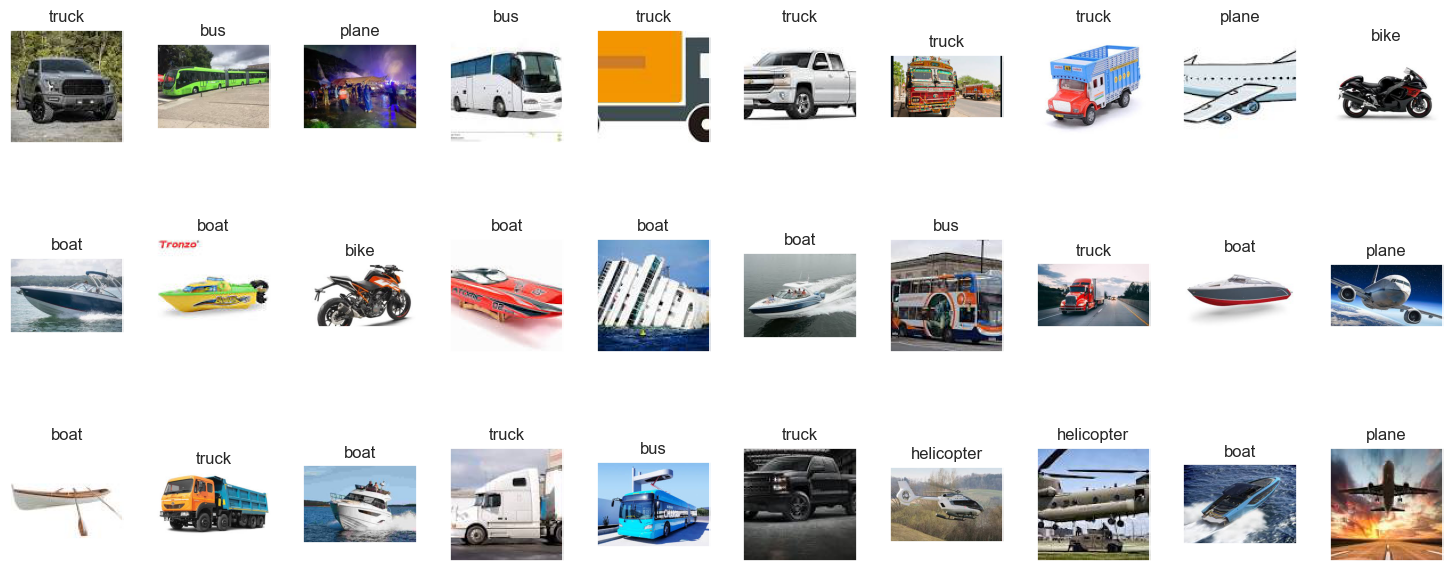

In [7]:
# Displays some pictures of the dataset

# subplots without scaling(subplot_kw - xticks/yticks)
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(15, 7),subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df01.Imagepath[i]))
    ax.set_title(df01.Label[i], fontsize = 12)
    
# distance between the pictures
plt.tight_layout(pad=2)
plt.show()

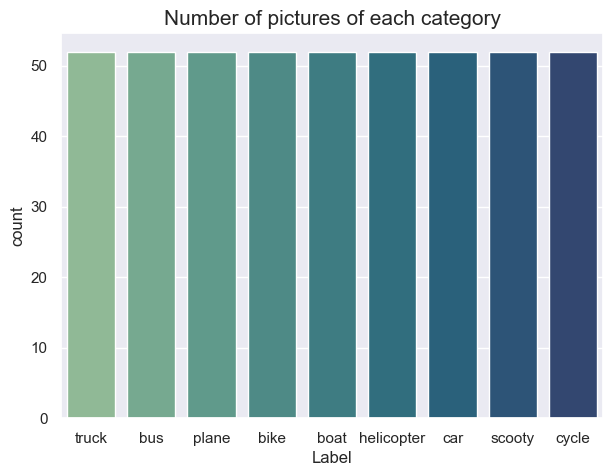

In [8]:
plt.figure(figsize=(7,5))

sns.countplot(data = df01, x = "Label", palette = "crest", order = df01['Label'].value_counts().index)
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

# Preparing images

In [9]:
from sklearn.model_selection import train_test_split

train_df01, test_df01 = train_test_split(df01, test_size=0.2, random_state=42)

In [10]:
# IMAGE LOADING AND DATA AUGMENTATION

# initialize generators - validation_split(testsize)
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input, validation_split=0.2)  

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

In [11]:
# Load images --> with subset split to X-Train and X-Test(80 % / 20 %)

def create_gen():

# X-Train
    train_img = train_gen.flow_from_dataframe(dataframe=train_df01, x_col="Imagepath", y_col="Label", 
            target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, 
            seed=0, subset='training', rotation_range=30, zoom_range=0.15, width_shift_range=0.2, 
            height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest")

# y-Train
    val_img = train_gen.flow_from_dataframe(dataframe=train_df01, x_col="Imagepath", y_col="Label", 
          target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=True, 
          seed=0, subset='validation', rotation_range=30, zoom_range=0.15, width_shift_range=0.2, 
          height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest")

# X-Test
    test_img = test_gen.flow_from_dataframe(dataframe=test_df01, x_col="Imagepath", y_col="Label", 
           target_size=(224, 224), color_mode='rgb', class_mode='categorical', batch_size=32, shuffle=False)
    
    return train_gen, test_gen, train_img, val_img, test_img

# Models

In [12]:
def get_model(model):
    
    # Loading model:

    kwargs = {'input_shape':(224, 224, 3),'include_top':False,'weights':'imagenet','pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(9, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model

In [13]:
# Dictionary with the models

models = {"ResNet101V2": {"model":tf.keras.applications.ResNet101V2, "perf":0},
          "Xception": {"model":tf.keras.applications.Xception, "perf":0},
          "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
          "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
          "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
          "NASNetMobile": {"model":tf.keras.applications.NASNetMobile, "perf":0},
          "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
          "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
          "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
          "VGG16": {"model":tf.keras.applications.VGG16, "perf":0}}

# Training 10 models with 3 epochs

In [14]:
from time import perf_counter

In [15]:
# Create the generators
train_gen,test_gen,train_img,val_img,test_img = create_gen()
print('\n')

# Fit the models
for name, model in models.items():
    
    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # Fit the model
    history = m.fit(train_img,validation_data=val_img,epochs=3,verbose=0)
    
    # Save the duration and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 300 validated image filenames belonging to 9 classes.
Found 74 validated image filenames belonging to 9 classes.
Found 94 validated image filenames belonging to 9 classes.







ResNet101V2          trained in 145.62 sec
83683744/83683744 [==============================] - 5s 0us/step
Xception             trained in 112.26 sec
219055592/219055592 [==============================] - 13s 0us/step
InceptionResNetV2    trained in 148.9 sec
51877672/51877672 [==============================] - 4s 0us/step
DenseNet169          trained in 98.63 sec
74836368/74836368 [==============================] - 5s 0us/step
DenseNet201          trained in 142.68 sec
19993432/19993432 [==============================] - 2s 0us/step
NASNetMobile         trained in 43.55 sec
17225924/17225924 [==============================] - 2s 0us/step
MobileNet            trained in 21.23 sec
9406464/9406464 [==============================] - 1s 0us/step
MobileNetV2          trained in 22.99 sec
234545216/234545216 

In [18]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [19]:
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_img)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_img.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df01.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)

3/3 [==============================] - 20s 7s/step


In [20]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], models[name]['acc'], models[name]['perf']])
    
df_results = pd.DataFrame(models_result, columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

,model,val_accuracy,accuracy,Training time (sec)
0,InceptionResNetV2,0.9189,0.9468,148.90
1,Xception,0.9189,0.9362,112.26
2,NASNetMobile,0.9459,0.9255,43.55
3,ResNet101V2,0.8919,0.8936,145.62
4,DenseNet201,0.9595,0.8936,142.68
5,MobileNet,0.8919,0.8936,21.23
6,ResNet152V2,0.9054,0.8936,241.04
7,DenseNet169,0.8514,0.8617,98.63
8,MobileNetV2,0.8649,0.8298,22.99
9,VGG16,0.6486,0.6277,257.95


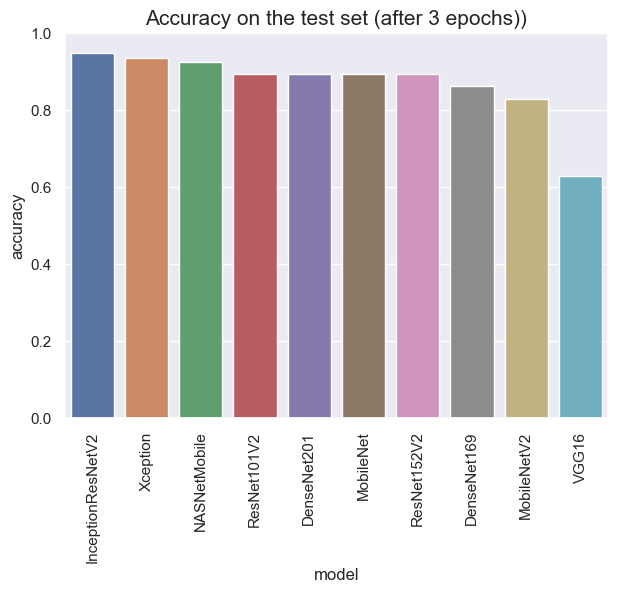

In [25]:
# Accuracy after 3 epochs

plt.figure(figsize = (7,5))

sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 3 epochs))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

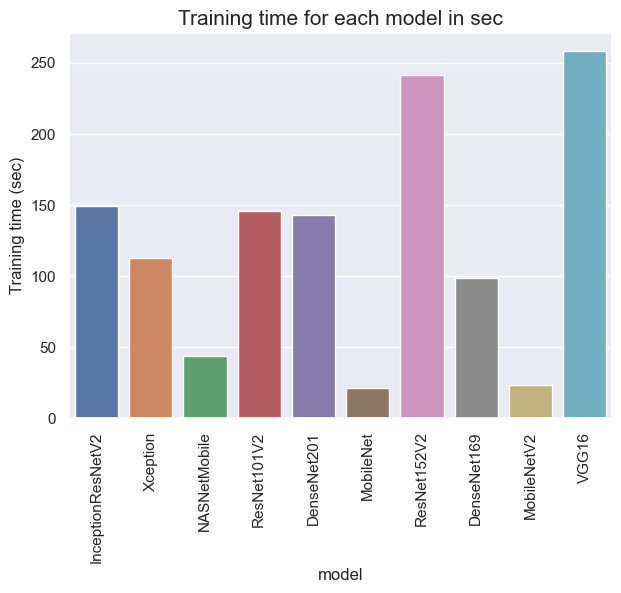

In [26]:
# Training Time

plt.figure(figsize = (7,5))

sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()

# Training the best 3 models with 10 epochs

In [29]:
model01 = get_model(tf.keras.applications.InceptionResNetV2)
model02 = get_model(tf.keras.applications.Xception)
model03 = get_model(tf.keras.applications.NASNetMobile)

In [30]:
# Training

history01 = model01.fit(train_img,validation_data=val_img,epochs=10)
history02 = model02.fit(train_img,validation_data=val_img,epochs=10)
history03 = model03.fit(train_img,validation_data=val_img,epochs=10)

Epoch 1/10
10/10 [==============================] - 51s 4s/step - loss: 1.2793 - accuracy: 0.6133 - val_loss: 0.4403 - val_accuracy: 0.8649
Epoch 2/10
10/10 [==============================] - 42s 4s/step - loss: 0.2826 - accuracy: 0.9267 - val_loss: 0.1870 - val_accuracy: 0.9324
Epoch 3/10
10/10 [==============================] - 41s 4s/step - loss: 0.1385 - accuracy: 0.9600 - val_loss: 0.1461 - val_accuracy: 0.9459
Epoch 4/10
10/10 [==============================] - 42s 4s/step - loss: 0.0969 - accuracy: 0.9667 - val_loss: 0.2092 - val_accuracy: 0.9054
Epoch 5/10
10/10 [==============================] - 41s 4s/step - loss: 0.0635 - accuracy: 0.9800 - val_loss: 0.2017 - val_accuracy: 0.9054
Epoch 6/10
10/10 [==============================] - 40s 4s/step - loss: 0.0479 - accuracy: 0.9900 - val_loss: 0.1938 - val_accuracy: 0.9324
Epoch 7/10
10/10 [==============================] - 39s 4s/step - loss: 0.0309 - accuracy: 0.9933 - val_loss: 0.1745 - val_accuracy: 0.9459
Epoch 8/10
10/10 [==

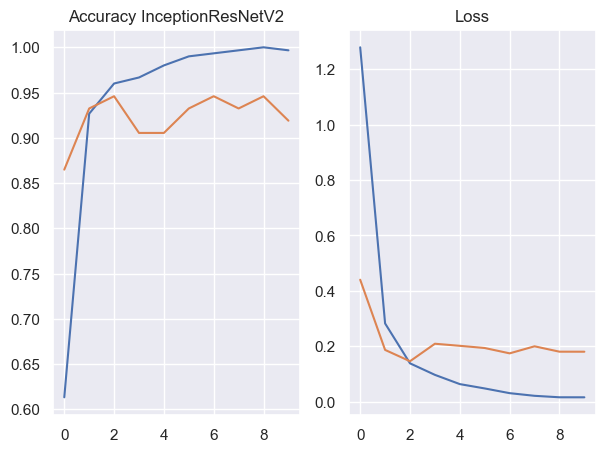

In [31]:
# Visualization Accuracy and Loss InceptionResNetV2

figure, axes = plt.subplots(1, 2, figsize=(7,5))

axes[0].plot(pd.DataFrame(history01.history)[['accuracy','val_accuracy']])
axes[0].set_title("Accuracy InceptionResNetV2")
axes[1].plot(pd.DataFrame(history01.history)[['loss','val_loss']])
axes[1].set_title("Loss")
plt.show()

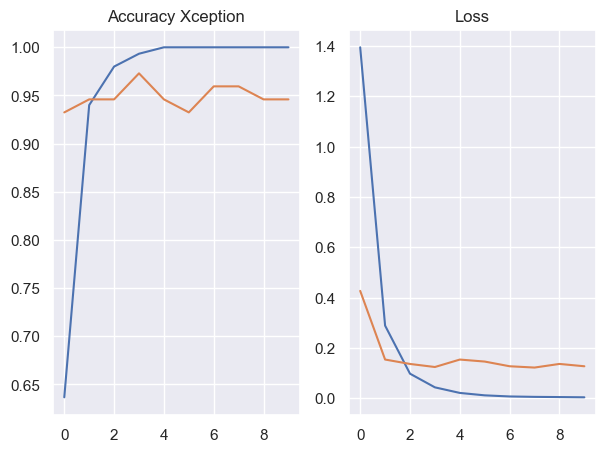

In [32]:
# Visualization Accuracy and Loss Xception

figure, axes = plt.subplots(1, 2, figsize=(7,5))

axes[0].plot(pd.DataFrame(history02.history)[['accuracy','val_accuracy']])
axes[0].set_title("Accuracy Xception")
axes[1].plot(pd.DataFrame(history02.history)[['loss','val_loss']])
axes[1].set_title("Loss")
plt.show()

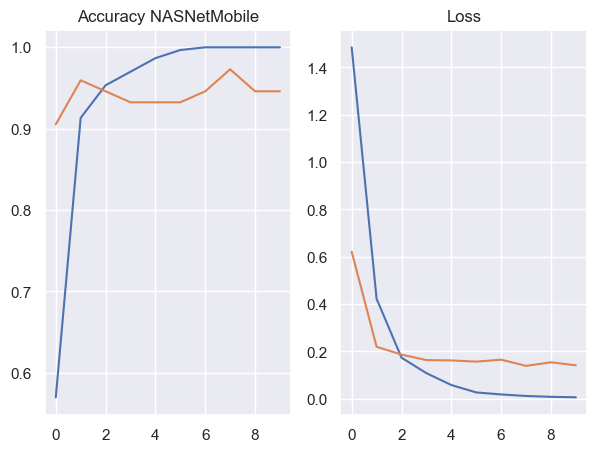

In [33]:
# Visualization Accuracy and Loss NASNetMobile

figure, axes = plt.subplots(1, 2, figsize=(7,5))

axes[0].plot(pd.DataFrame(history03.history)[['accuracy','val_accuracy']])
axes[0].set_title("Accuracy NASNetMobile")
axes[1].plot(pd.DataFrame(history03.history)[['loss','val_loss']])
axes[1].set_title("Loss")
plt.show()

In [35]:
# Predicting the label of the test_images InceptionResNetV2

pred01 = model01.predict(test_img)
pred01 = np.argmax(pred01,axis=1)

# Map the label
labels = (train_img.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred01 = [labels[k] for k in pred01]

3/3 [==============================] - 9s 3s/step


In [37]:
# Predicting the label of the test_images Xception

pred02 = model02.predict(test_img)
pred02 = np.argmax(pred02,axis=1)

# Map the label
labels = (train_img.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred02 = [labels[k] for k in pred02]

3/3 [==============================] - 7s 2s/step


In [39]:
# Predicting the label of the test_images NASNetMobile

pred03 = model03.predict(test_img)
pred03 = np.argmax(pred03,axis=1)

# Map the label
labels = (train_img.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred03 = [labels[k] for k in pred03]

3/3 [==============================] - 2s 540ms/step


In [40]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [41]:
# Accuracy InceptionResNetV2

y_test = list(test_df01.Label)
acc = accuracy_score(y_test,pred01)
print(f'--> Accuracy on the test set: {acc * 100:.2f}%')

--> Accuracy on the test set: 96.81%


In [44]:
# Accuracy Xception

y_test = list(test_df01.Label)
acc = accuracy_score(y_test,pred02)
print(f'--> Accuracy on the test set: {acc * 100:.2f}%')

--> Accuracy on the test set: 93.62%


In [45]:
# Accuracy NASNetMobile

y_test = list(test_df01.Label)
acc = accuracy_score(y_test,pred03)
print(f'--> Accuracy on the test set: {acc * 100:.2f}%')

--> Accuracy on the test set: 93.62%


In [46]:
# Classification Report InceptionResNetV2

class_report = classification_report(y_test, pred01, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

        bike       1.00      1.00      1.00        13
        boat       1.00      1.00      1.00        13
         bus       1.00      0.91      0.95        11
         car       1.00      1.00      1.00         8
       cycle       1.00      1.00      1.00        10
  helicopter       1.00      0.91      0.95        11
       plane       0.93      0.93      0.93        14
      scooty       1.00      1.00      1.00         9
       truck       0.71      1.00      0.83         5

    accuracy                           0.97        94
   macro avg       0.96      0.97      0.96        94
weighted avg       0.97      0.97      0.97        94



In [47]:
# Classification Report Xception

class_report = classification_report(y_test, pred02, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

        bike       1.00      0.92      0.96        13
        boat       1.00      0.92      0.96        13
         bus       0.85      1.00      0.92        11
         car       1.00      1.00      1.00         8
       cycle       1.00      1.00      1.00        10
  helicopter       0.83      0.91      0.87        11
       plane       0.92      0.86      0.89        14
      scooty       0.90      1.00      0.95         9
       truck       1.00      0.80      0.89         5

    accuracy                           0.94        94
   macro avg       0.94      0.93      0.94        94
weighted avg       0.94      0.94      0.94        94



In [48]:
# Classification Report NASNetMobile

class_report = classification_report(y_test, pred03, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

        bike       1.00      1.00      1.00        13
        boat       0.92      0.92      0.92        13
         bus       0.91      0.91      0.91        11
         car       1.00      1.00      1.00         8
       cycle       1.00      1.00      1.00        10
  helicopter       0.77      0.91      0.83        11
       plane       1.00      0.93      0.96        14
      scooty       1.00      0.89      0.94         9
       truck       0.80      0.80      0.80         5

    accuracy                           0.94        94
   macro avg       0.93      0.93      0.93        94
weighted avg       0.94      0.94      0.94        94



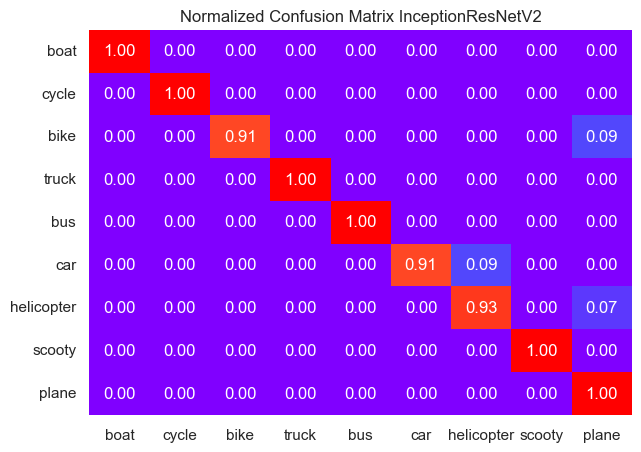

In [49]:
# Confusion Matrix InceptionResNetV2

cf_matrix = confusion_matrix(y_test, pred01, normalize='true')
plt.figure(figsize = (7,5))
sns.heatmap(cf_matrix,annot=True,xticklabels=set(y_test),yticklabels=set(y_test),cbar=False,cmap="rainbow",fmt=".2f")
plt.title('Normalized Confusion Matrix InceptionResNetV2', fontsize = 12)
plt.xticks()
plt.yticks()
plt.show()

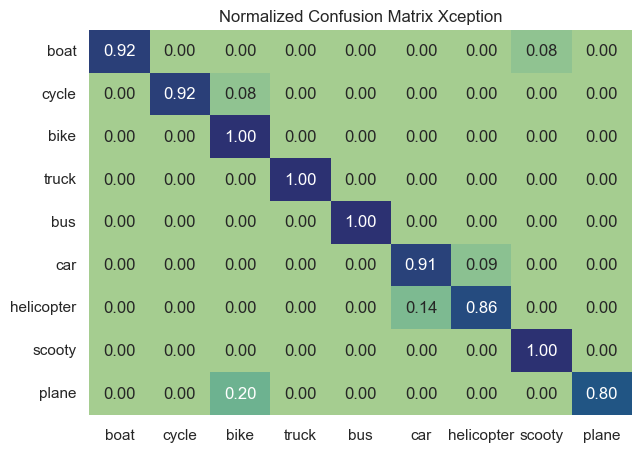

In [50]:
# Confusion Matrix Xception

cf_matrix = confusion_matrix(y_test, pred02, normalize='true')
plt.figure(figsize = (7,5))
sns.heatmap(cf_matrix,annot=True,xticklabels=set(y_test),yticklabels=set(y_test),cbar=False,cmap="crest",fmt=".2f")
plt.title('Normalized Confusion Matrix Xception', fontsize = 12)
plt.xticks()
plt.yticks()
plt.show()

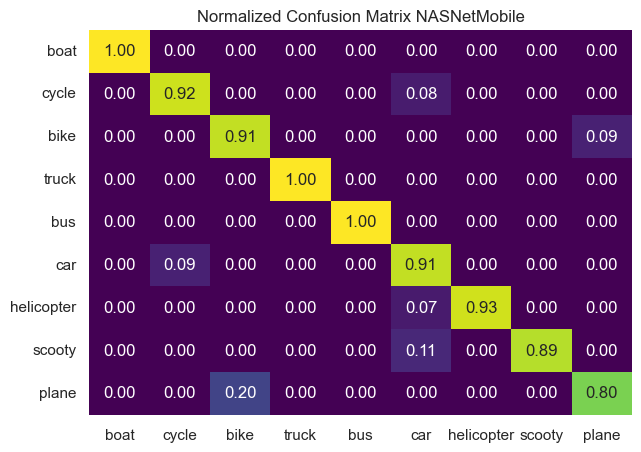

In [52]:
# Confusion Matrix NASNetMobile

cf_matrix = confusion_matrix(y_test, pred03, normalize='true')
plt.figure(figsize = (7,5))
sns.heatmap(cf_matrix,annot=True,xticklabels=set(y_test),yticklabels=set(y_test),cbar=False,cmap="viridis",fmt=".2f")
plt.title('Normalized Confusion Matrix NASNetMobile', fontsize = 12)
plt.xticks()
plt.yticks()
plt.show()

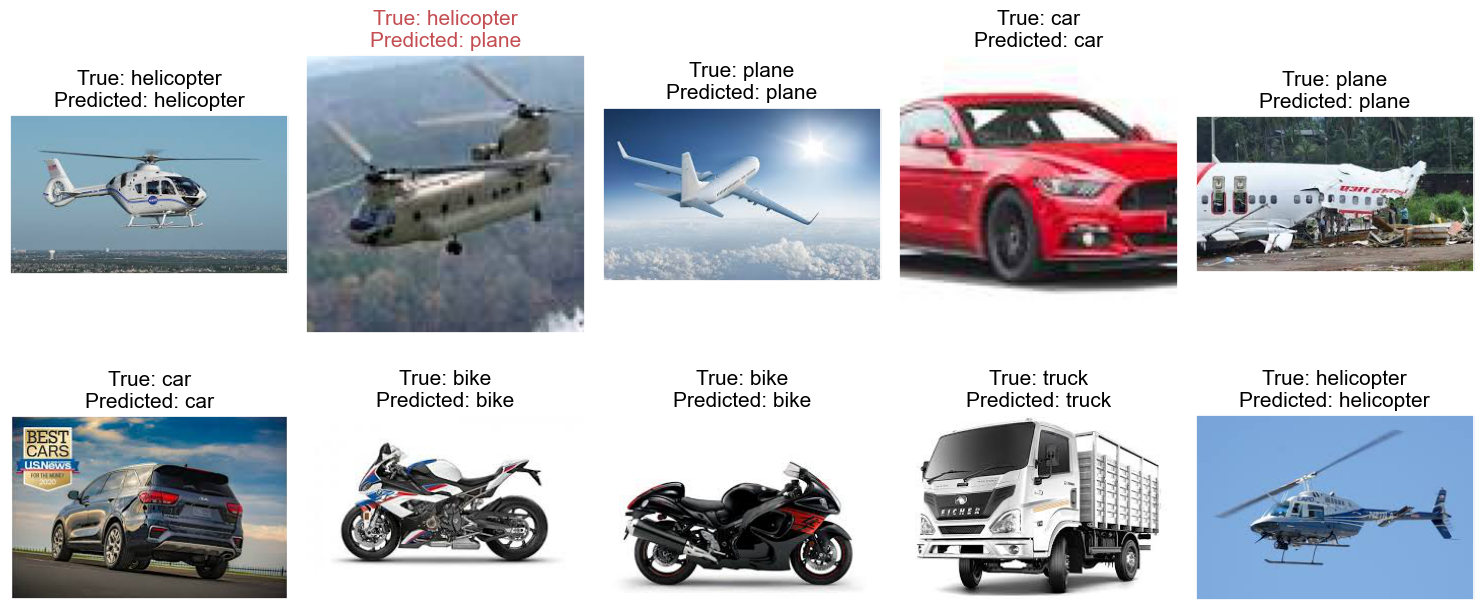

In [53]:
# Display picture of the dataset with their labels - InceptionResNetV2:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7),subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    color = "black"
    if pred01[i].split('_')[0]!=test_df01.Label.iloc[i].split('_')[0]: color="r"
    ax.imshow(plt.imread(test_df01.Imagepath.iloc[i]))
    ax.set_title(f"True: {test_df01.Label.iloc[i].split('_')[0]}\nPredicted: {pred01[i].split('_')[0]}", 
                 fontsize = 15, color = color)
plt.tight_layout()
plt.show()

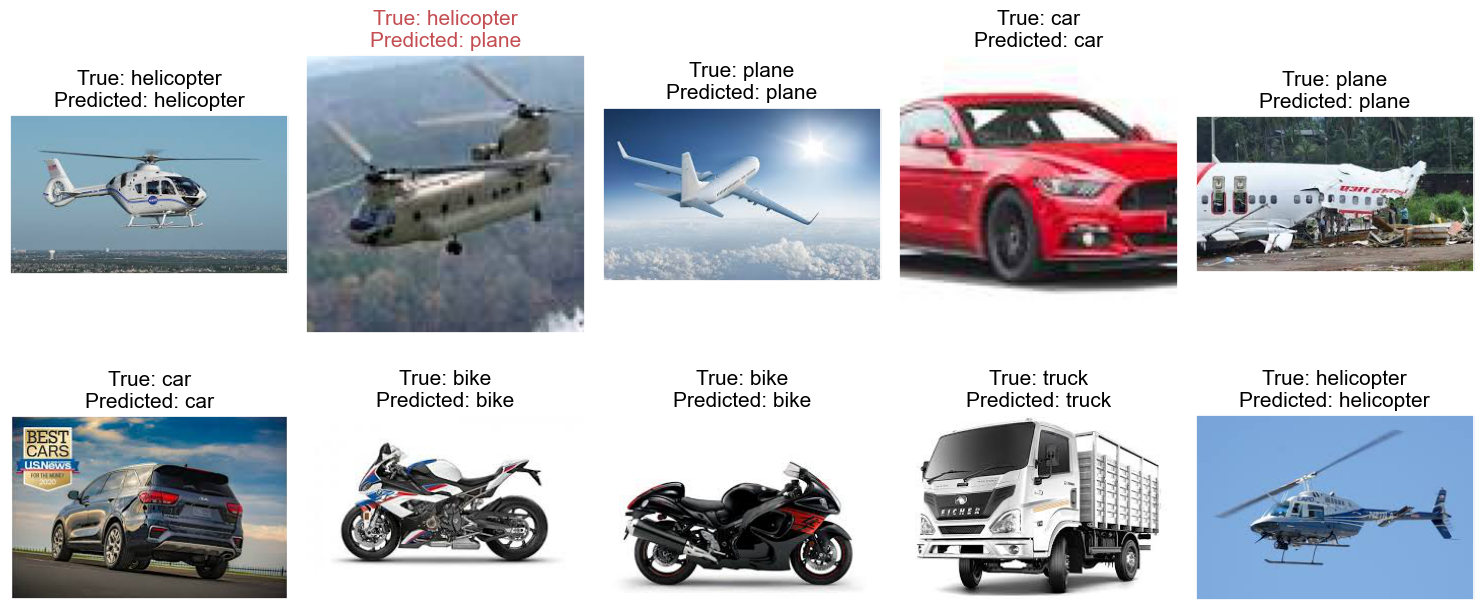

In [54]:
# Display picture of the dataset with their labels - Xception:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7),subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    color = "black"
    if pred02[i].split('_')[0]!=test_df01.Label.iloc[i].split('_')[0]: color="r"
    ax.imshow(plt.imread(test_df01.Imagepath.iloc[i]))
    ax.set_title(f"True: {test_df01.Label.iloc[i].split('_')[0]}\nPredicted: {pred02[i].split('_')[0]}", 
                 fontsize = 15, color = color)
plt.tight_layout()
plt.show()

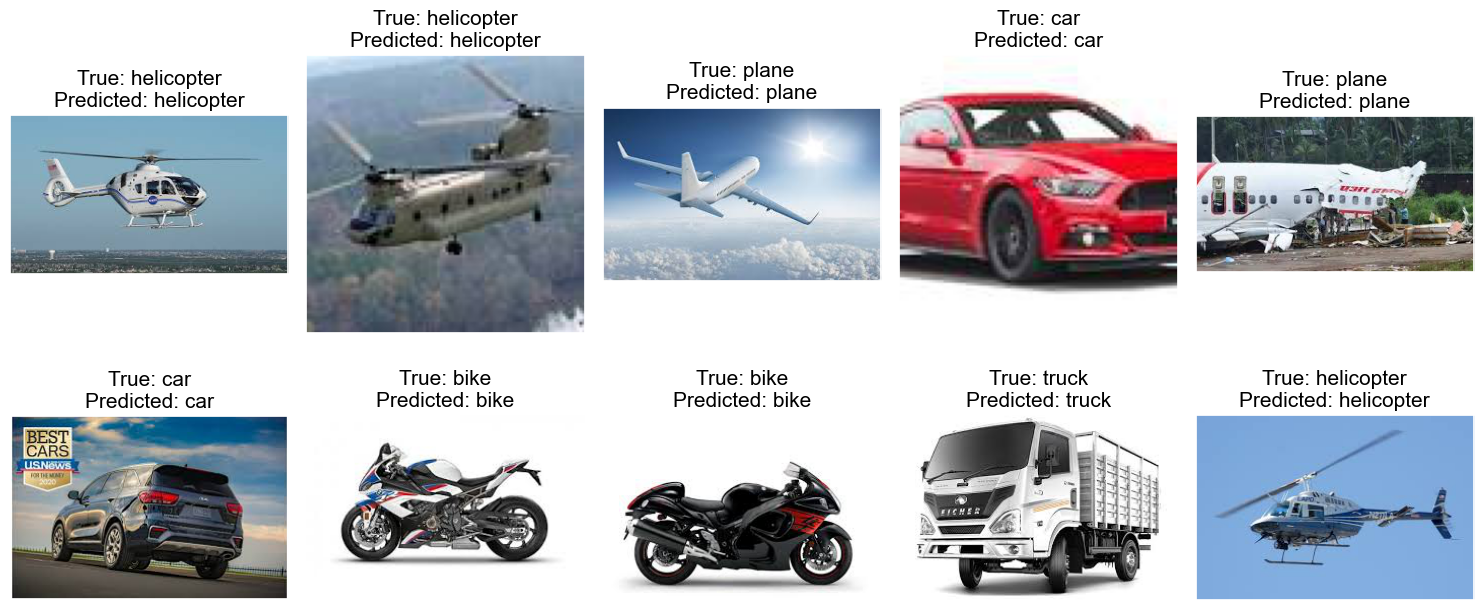

In [55]:
# Display picture of the dataset with their labels - NASNetMobile:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7),subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    color = "black"
    if pred03[i].split('_')[0]!=test_df01.Label.iloc[i].split('_')[0]: color="r"
    ax.imshow(plt.imread(test_df01.Imagepath.iloc[i]))
    ax.set_title(f"True: {test_df01.Label.iloc[i].split('_')[0]}\nPredicted: {pred03[i].split('_')[0]}", 
                 fontsize = 15, color = color)
plt.tight_layout()
plt.show()